<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> RAMP on qualitative and quantitative non-invasive monitoring of anti-cancer drugs </h2>

<i>Camille Marini (LTCI/CNRS), Alex Gramfort (LTCI/Télécom ParisTech), Sana Tfaili (Lip(Sys)²/UPSud), Laetitia Le (Lip(Sys)²/UPSud), Mehdi Cherti (LAL/CNRS), Balázs Kégl (LAL/CNRS)</i>

## Maxime Bellec report

### Data analysis

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('train.csv')

y_df = data[['molecule', 'concentration']]
X_df = data.drop(['molecule', 'concentration'], axis=1)
spectra = X_df['spectra'].values                                        
spectra = np.array([np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])    
X_df['spectra'] = spectra.tolist()

In [3]:
# Target for classification
molecule = y_df['molecule'].values
# Target for regression
concentration = y_df['concentration'].values
# "Raw" features
X = spectra

We need to predict molecule type and concentration. Let's see how they vary with the spectrum

#### Mean spectrum as a function of the molecule type

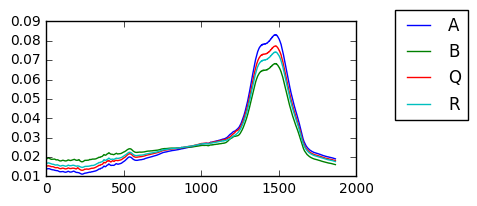

In [4]:
plt.rcParams['figure.figsize'] = (4, 2)
# Mean Raman spectra for each type of molecule
for mol in np.unique(molecule):
    plt.plot(np.mean(X[molecule == mol, :], axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

# Dimensionality reduction

We have 999 samples and 1800 features : most model
    won't make a lot of sense. Since the raman spetras are similar,
    the intrisic dimension should be smaller. PCA should be able to capture that

## PCA

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=20)
X_reduced = pca.fit_transform(X)

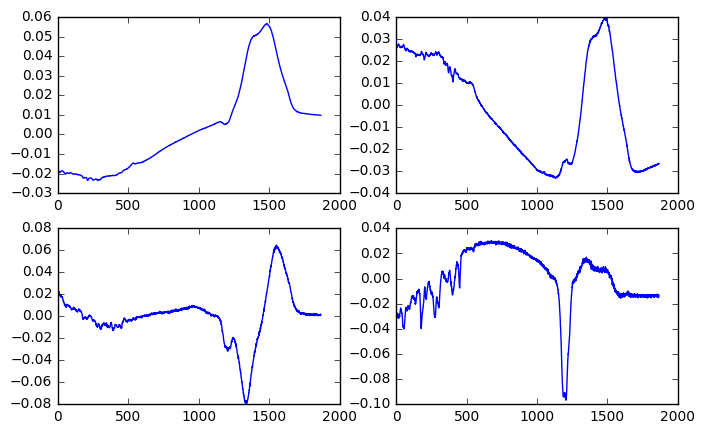

In [7]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.subplot(2, 2, 1)
plt.plot(-pca.components_[0])
plt.subplot(2, 2, 2)
plt.plot(-pca.components_[1])
plt.subplot(2, 2, 3)
plt.plot(-pca.components_[2])
plt.subplot(2, 2, 4)
plt.plot(-pca.components_[3])

The first component is the average sprectum, the other components capture information such as height and width of the peak or shape of the very beginning of the spectrum.

## Distribution of the molecules along the 2 principal axis

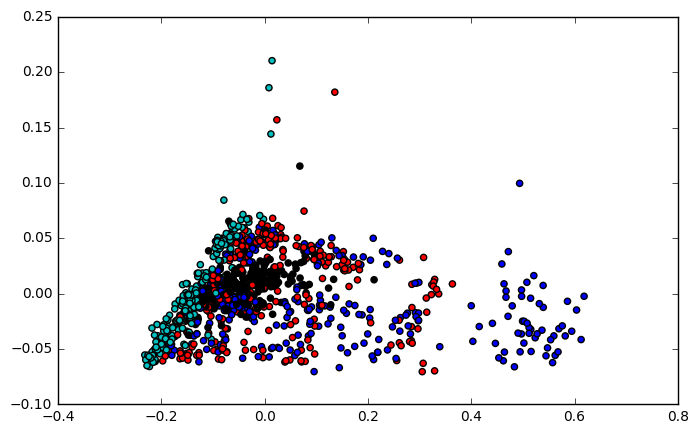

In [8]:
reverse_labels = {'A': 'c', 'B': 'b', 'Q': 'k', 'R': 'r'}
c = map(lambda x: reverse_labels[x], molecule)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=c)

## Distribution of the concentration along the 2 principal axis

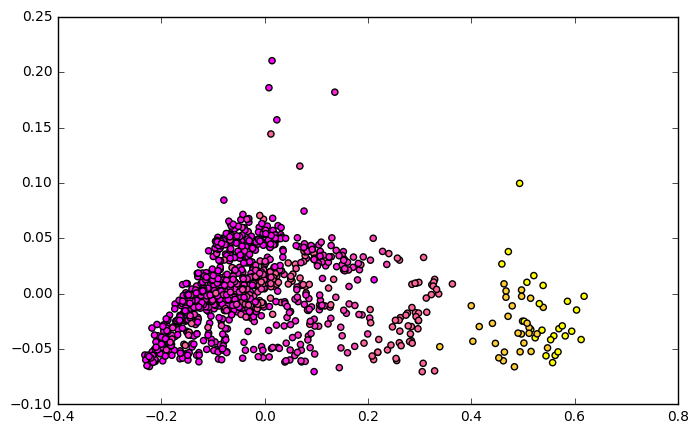

In [9]:
reverse_labels = {'A': 'c', 'B': 'b', 'Q': 'k', 'R': 'r'}
c = map(lambda x: reverse_labels[x], molecule)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=concentration, cmap='spring')

PCA seems relevant for this task, as only the 2 principal axis
are enough to have a good first separation of the molecules and concentration.

## Fourier

In [10]:
def get_fft(x):
    a = np.fft.rfft(x)
    return np.concatenate([a.real[:70], a.imag[1:70]])

def transform_fft(X):
    return np.apply_along_axis(get_fft, 1, X)

In [11]:
X_fft = transform_fft(X)

Fourier transform allows to reconstruct the signal with less noise :

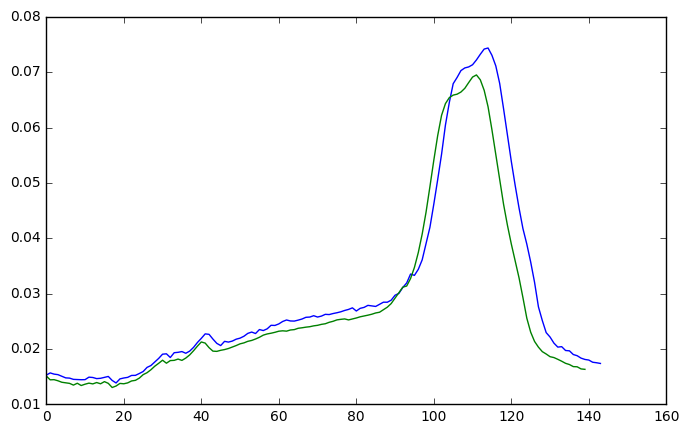

In [12]:
plt.plot(X[0][np.arange(0, X[0].size + 1, X[0].size / 140)])
plt.plot(0.07*np.fft.irfft(np.fft.rfft(X[0]), 140))

We will see later that a PCA on the Fourier transform performs similarily than a PCA on X in terms of performance,
but does not fail on the same data, so that keeping both is relevant.

# Feature engineering

I first used only X as a feature, and then tried to add some more. They did not perform very well but could be interesting.

## Slope

As we can see on the mean spectrum for each molecule, the spectrum for the molecule A is small for small frequencies, than highest for big frequencies. So that the slope (linear approximation) of the spectrum will be higher.

I computed two kinds of slope. Because classical least squares approximation is influenced a lot by the concentration
of the molecule, I also computed the least absolute error slope, that is not influenced by large outliers.

In [13]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
r = RANSACRegressor(LinearRegression())
def get_l1_slope(array):
    """
    We use a linear regression with least absolute loss to be resistent
    to the high peak
    """
    n_features = 1200
    return r.fit(np.arange(1200).reshape((1200, 1)), array[:1200]).estimator_.coef_[0]


def get_l2_slope(x):
    """
    l2 slope is an easy computation
    """
    n = x.shape[0]
    return np.dot(range(n), x) / n - (n - 1) /2. * x.mean()

In [14]:
if False:
    l1_slope = np.apply_along_axis(get_l1_slope, 1, X)
    l2_slope = np.apply_along_axis(get_l2_slope, 1, X)

    # influence on the molecule type and concentration

    slopes = pd.DataFrame([l1_slope, l2_slope, molecule, concentration]).T
    slopes.columns = 'l1', 'l2', 'molecule', 'concentration'
    slopes.l1 = 1e5*slopes.l1.astype(np.float64)
    slopes.l2 = slopes.l2.astype(np.float64)
    df = slopes.groupby('molecule')['l1', 'l2'].agg('mean')

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>l1</th>
      <th>l2</th>
    </tr>
    <tr>
      <th>molecule</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>A</th>
      <td>1.693955</td>
      <td>6.478152</td>
    </tr>
    <tr>
      <th>B</th>
      <td>0.781880</td>
      <td>3.661328</td>
    </tr>
    <tr>
      <th>Q</th>
      <td>1.476900</td>
      <td>5.517031</td>
    </tr>
    <tr>
      <th>R</th>
      <td>1.268023</td>
      <td>4.916396</td>
    </tr>
  </tbody>
</table>


The average slope is indeed much smaller for molecule B than for the others, and relatively different for each molecule. Keeping both as features is a bad idea for most models because they are strongly correlated, making the optimisation slow, so I only kept the l2 slope (faster to compute). There is still information in keeping both though, as shown by following plots (top: concentration, bottom: molecule).

<img src='https://dl.dropboxusercontent.com/s/dp4z7jje959l0d8/Capture%20d%27%C3%A9cran%202016-12-15%2015.28.53.png?dl=0' width='500px'>
<img src='https://dl.dropboxusercontent.com/s/veeh74msk8vd3rq/Capture%20d%27%C3%A9cran%202016-12-15%2015.29.06.png?dl=0' width='500px'>

---

# Models

## Failed idea: predict a model as a linear combination of the others

The idea is that the same molecule in different solutions and concentration have similar spectrum. What's more, we could imagine that the spectrum is an approximation of a linear combination of the spectrum of the soluté and that of the molecule. So that

$$Spectrum(molecule \space M1, soluté \space S1, concentration \space C1) = \\ K(concentration) \space Spectrum(soluté \space S1) + \\ K'(concentration) \space Spectum(molecule \space M1, concentration \space C2)$$

Even though we do not have access to $Spectrum(soluté \space S1)$, in that case we would have

$$Spectrum(molecule \space M1, soluté \space S1, concentration \space C1) = \\ K(concentration) \space Spectum(molecule \space M1, concentration \space C2) + \\ K'(concentration) \space Spectum(molecule \space M1, concentration \space C2)$$


So we predict a spectrum as a linear combination of the other sprectrum. Since there are many other spectrum,
we will use a Lasso penalization in order to have very few other spectrum in that linear combination.

Once we have that combination, we predict the molecule to be the most frequent found amongst the spectrum having non-null coefficients, and the concentration to be the weighted average of the corresponding spectrum.

In [15]:
# both train and test data
full_df = X_df.join(y_df)

#### <span style='color:gray'>Warning: code in next cell takes ~30min to run, so I print the result but the code does not actually run</span>

In [16]:
from sklearn.linear_model import Lasso
pred_molecule = pd.Series(np.zeros(999))
pred_concentration = pd.Series(np.zeros(999))
similar_molecules = pd.Series(np.zeros(999))

n_samples = X.shape[0]

# change 0 to 999 for the cell to actually run
for ix in range(0):
    print(ix)
    # have every spectrum but the one we are currently predicting
    mask = np.arange(n_samples) != ix
    X_minus_ix = X[mask, :]
    
    # linear lasso to predict current spectrum as sparse linear combination
    # of the others
    reg = Lasso(alpha=1e-5)
    reg.fit(X_minus_ix.T, X[ix])
    
    # keeping only non-null indices
    non_null_indices = reg.coef_ != 0
    non_null_coefs = reg.coef_[non_null_indices]
    
    corr_df = full_df[mask][non_null_indices]
    # the predicted concentration is a weighted average of the coefficients of
    # the linear combination
    pred_concentration[ix] = np.dot(corr_df.concentration.values, non_null_coefs)\
                             / non_null_coefs.sum()
    # the predicted molecule is the most frequent molecule 
    pred_molecule[ix] = corr_df.molecule.value_counts().idxmax()
    similar_molecules[ix] = non_null_coefs.size

if False:
    res = pd.DataFrame([molecule, pred_molecule, concentration, pred_concentration, similar_molecules]).T
    res.columns = 'molecule', 'predicted_molecule', 'concentration', 'predicted_concentration', 'n_molecules'
    # the mare scare
    np.mean(np.abs((res.predicted_concentration - res.concentration)) / res.concentration)
    # the confusion matrix
    from sklearn.metrics import confusion_matrix
    confusion_matrix(res.molecule, res.predicted_molecule)
    # 0/1 loss
    (res.molecule == res.predicted_molecule).mean()

print("Mare score for linear combination predictor: 0.56504819375707427")
print("confusion matrix for linear combination predictor: \n{}".format(np.array([[243,   0,   0,   0], [154,  91,   0,  14],[233,   4,   0,   0],[217,  22,   0,  21]])))
print("0/1 loss for molecule prediction: 0.35535535535535534".format())

Mare score for linear combination predictor: 0.56504819375707427
confusion matrix for linear combination predictor: 
[[243   0   0   0]
 [154  91   0  14]
 [233   4   0   0]
 [217  22   0  21]]
0/1 loss for molecule prediction: 0.35535535535535534


The results are interesting (mare of 0.56, not very good but not stupid) for the concentration, but very bad for the predicted molecule (though still above random). For some reason, the predicted molecule is almost only A and B.

This model is intersting in that it has no hyperparameters, but **does not have a good prediction, we can drop it**.

---

## More traditional models and parameter selection

I used scikit-learn's implementations and Random Forests and SVM, as well as xgboost's regression trees.

The model selection is done using a grid search with cross validation.
For each model, I tried using both the PCA on the spectrum and the PCA of the Fourier transform of the spectrum, they both had interesting results.

## Parameter selection using grid search and cross validation

We'll have a look at one example since it's similar for others

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

At the beginning, the grid search should only contain a few (2-3) different values for each parameter, as we'll do
n_parameter_1 * n_parameter_2 * n_fold trainings. They should cover a large range, that can be refined (a bit, to avoid overfitting) after around best values

In [18]:
if False:
    param_grid = [{'n_estimators': [20, 100, 1000], 'max_features': [5, 10, 20]}]

    # for classification, the default scoring value is the one of the problem (0/1 loss)
    # for regression, we would passe scoring=mare_loss
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid)

    grid_search.fit(X_reduced, molecule)

    print(grid_search.best_params_)
    pd.DataFrame(grid_search.cv_results_)
print("best params: {}".format({'max_features': 5, 'n_estimators': 1000}))

best params: {'max_features': 5, 'n_estimators': 1000}


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>mean_fit_time</th>
      <th>mean_score_time</th>
      <th>mean_test_score</th>
      <th>mean_train_score</th>
      <th>param_max_features</th>
      <th>param_n_estimators</th>
      <th>params</th>
      <th>rank_test_score</th>
      <th>split0_test_score</th>
      <th>split0_train_score</th>
      <th>split1_test_score</th>
      <th>split1_train_score</th>
      <th>split2_test_score</th>
      <th>split2_train_score</th>
      <th>std_fit_time</th>
      <th>std_score_time</th>
      <th>std_test_score</th>
      <th>std_train_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.147008</td>
      <td>0.023465</td>
      <td>0.912913</td>
      <td>1.000000</td>
      <td>5</td>
      <td>20</td>
      <td>{u'max_features': 5, u'n_estimators': 20}</td>
      <td>4</td>
      <td>0.931138</td>
      <td>1.000000</td>
      <td>0.894895</td>
      <td>1.000000</td>
      <td>0.912651</td>
      <td>1.000000</td>
      <td>0.026022</td>
      <td>0.008019</td>
      <td>0.014808</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.666344</td>
      <td>0.083507</td>
      <td>0.922923</td>
      <td>1.000000</td>
      <td>5</td>
      <td>100</td>
      <td>{u'max_features': 5, u'n_estimators': 100}</td>
      <td>2</td>
      <td>0.946108</td>
      <td>1.000000</td>
      <td>0.903904</td>
      <td>1.000000</td>
      <td>0.918675</td>
      <td>1.000000</td>
      <td>0.058890</td>
      <td>0.011265</td>
      <td>0.017501</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>2</th>
      <td>6.358472</td>
      <td>0.816569</td>
      <td>0.924925</td>
      <td>1.000000</td>
      <td>5</td>
      <td>1000</td>
      <td>{u'max_features': 5, u'n_estimators': 1000}</td>
      <td>1</td>
      <td>0.946108</td>
      <td>1.000000</td>
      <td>0.909910</td>
      <td>1.000000</td>
      <td>0.918675</td>
      <td>1.000000</td>
      <td>0.370262</td>
      <td>0.052399</td>
      <td>0.015432</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.171352</td>
      <td>0.017605</td>
      <td>0.902903</td>
      <td>0.998998</td>
      <td>10</td>
      <td>20</td>
      <td>{u'max_features': 10, u'n_estimators': 20}</td>
      <td>6</td>
      <td>0.940120</td>
      <td>0.998496</td>
      <td>0.864865</td>
      <td>0.998498</td>
      <td>0.903614</td>
      <td>1.000000</td>
      <td>0.007739</td>
      <td>0.001743</td>
      <td>0.030750</td>
      <td>0.000708</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.795902</td>
      <td>0.085024</td>
      <td>0.906907</td>
      <td>1.000000</td>
      <td>10</td>
      <td>100</td>
      <td>{u'max_features': 10, u'n_estimators': 100}</td>
      <td>5</td>
      <td>0.928144</td>
      <td>1.000000</td>
      <td>0.888889</td>
      <td>1.000000</td>
      <td>0.903614</td>
      <td>1.000000</td>
      <td>0.017887</td>
      <td>0.008550</td>
      <td>0.016205</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>5</th>
      <td>8.654545</td>
      <td>0.874869</td>
      <td>0.915916</td>
      <td>1.000000</td>
      <td>10</td>
      <td>1000</td>
      <td>{u'max_features': 10, u'n_estimators': 1000}</td>
      <td>3</td>
      <td>0.928144</td>
      <td>1.000000</td>
      <td>0.891892</td>
      <td>1.000000</td>
      <td>0.927711</td>
      <td>1.000000</td>
      <td>0.260688</td>
      <td>0.008321</td>
      <td>0.016988</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>6</th>
      <td>0.213665</td>
      <td>0.017699</td>
      <td>0.885886</td>
      <td>0.999500</td>
      <td>20</td>
      <td>20</td>
      <td>{u'max_features': 20, u'n_estimators': 20}</td>
      <td>9</td>
      <td>0.889222</td>
      <td>1.000000</td>
      <td>0.870871</td>
      <td>1.000000</td>
      <td>0.897590</td>
      <td>0.998501</td>
      <td>0.014222</td>
      <td>0.002851</td>
      <td>0.011153</td>
      <td>0.000707</td>
    </tr>
    <tr>
      <th>7</th>
      <td>1.204252</td>
      <td>0.099529</td>
      <td>0.887888</td>
      <td>1.000000</td>
      <td>20</td>
      <td>100</td>
      <td>{u'max_features': 20, u'n_estimators': 100}</td>
      <td>8</td>
      <td>0.898204</td>
      <td>1.000000</td>
      <td>0.876877</td>
      <td>1.000000</td>
      <td>0.888554</td>
      <td>1.000000</td>
      <td>0.030286</td>
      <td>0.021612</td>
      <td>0.008726</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>8</th>
      <td>10.848640</td>
      <td>1.180378</td>
      <td>0.888889</td>
      <td>1.000000</td>
      <td>20</td>
      <td>1000</td>
      <td>{u'max_features': 20, u'n_estimators': 1000}</td>
      <td>7</td>
      <td>0.892216</td>
      <td>1.000000</td>
      <td>0.879880</td>
      <td>1.000000</td>
      <td>0.894578</td>
      <td>1.000000</td>
      <td>0.383802</td>
      <td>0.461439</td>
      <td>0.006443</td>
      <td>0.000000</td>
    </tr>
  </tbody>
</table>

## Chosen models

After choosing parameters with cross validation for each, I kept the following models for classification:

In [19]:
from xgboost import XGBClassifier

In [20]:
rfc = RandomForestClassifier(n_estimators=300, max_features=5)
rfc_fft = RandomForestClassifier(n_estimators=300, max_features=5)
svc = SVC(C=1e7, kernel='rbf', probability=True)
svc_fft = SVC(C=1e7, kernel='rbf', probability=True)
bst = XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=500,
                    objective='multi:softprob', subsample=0.2)

## Model aggregation

There are different possible aggreation:
- chose the most likely (multiply the probabilities)
- chose the argmax of the probabilities
- keep only the best
- chose the most voted
- custom

I tried all different aggregations, evaluating them on many folds. The best aggregations were most voted and most likely, giving very similar results.

The next cell shows how I did it, but does not run (takes a long time)

In [21]:
# change to other than 0 for code to run
for i in range(0):
    skf = ShuffleSplit(n_splits=2, test_size=0.2)

    train_is, test_is = next(skf.split(y_df))

    X_train_df = X_df.iloc[train_is].copy()
    y_train_df = y_df.iloc[train_is].copy()
    X_test_df = X_df.iloc[test_is].copy()
    y_test_df = y_df.iloc[test_is].copy()
    y_train_clf = y_train_df['molecule'].values
    y_train_reg = y_train_df['concentration'].values
    y_test_clf = y_test_df['molecule'].values
    y_test_reg = y_test_df['concentration'].values

    fe_clf = feature_extractor_clf.FeatureExtractorClf()
    fe_clf.fit(X_train_df, y_train_df)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)

    X, X_fft = X_train_array_clf

    rfc = RandomForestClassifier(n_estimators=300, max_features=5)
    rfc_fft = RandomForestClassifier(n_estimators=300, max_features=5)
    svc = SVC(C=1e7, kernel='rbf', probability=True)
    svc_fft = SVC(C=1e7, kernel='rbf', probability=True)
    boost_params = {
        'max_depth': 6,
        'eta': 1,
        'gamma': 0,
        'lambda': 0,
        'silent':1,
        'objective':'multi:softprob',
        'n_thread': 4,
        'num_class': 4,
        'eval_metric': 'mlogloss'
    }

    y_train_clf.shape

    rfc.fit(X, y_train_clf)
    rfc_fft.fit(X_fft, y_train_clf)
    svc.fit(X, y_train_clf)
    svc_fft.fit(X_fft, y_train_clf)
    dtrain = xgb.DMatrix(X, label=float_labels(y_train_clf))
    dtrain_fft = xgb.DMatrix(X_fft, label=float_labels(y_train_clf))
    bst = xgb.train(boost_params, dtrain, num_boost_round=50)
    bst_fft = xgb.train(boost_params, dtrain_fft, num_boost_round=50)

    X_test, X_test_fft = X_test_array_clf

    rfc_prob = rfc.predict_proba(X_test)
    rfc_pred = labels[np.argmax(rfc_prob, axis=1)]

    rfc_fft_prob = rfc_fft.predict_proba(X_test_fft)
    rfc_fft_pred = labels[np.argmax(rfc_fft_prob, axis=1)]

    svc_prob = svc.predict_proba(X_test)
    svc_pred = labels[np.argmax(svc_prob, axis=1)]

    svc_fft_prob = svc_fft.predict_proba(X_test_fft)
    svc_fft_pred = labels[np.argmax(svc_fft_prob, axis=1)]

    bst_prob = bst.predict(xgb.DMatrix(X_test))
    bst_pred = labels[np.argmax(bst_prob, axis=1)]

    bst_fft_prob = bst_fft.predict(xgb.DMatrix(X_test_fft))
    bst_fft_pred = labels[np.argmax(bst_fft_prob, axis=1)]

    tot_prob = rfc_prob * rfc_fft_prob * svc_prob * svc_fft_prob * bst_prob * bst_fft_prob
    tot_pred = labels[np.argmax(tot_prob, axis=1)]

    res = pd.DataFrame([rfc_pred, svc_pred, rfc_fft_pred, svc_fft_pred, bst_pred, bst_fft_pred, tot_pred, y_test_clf]).T

    res.columns = 'rfc', 'svc', 'rfc_fft', 'svc_fft', 'bst', 'bst_fft', 'tot', 'true'

    def get_res(row):
        counts = row.value_counts()
        if counts.max() >= 4:
            return counts.argmax()
        else:
            return row['svc']

    res['most_common'] = res.iloc[:, :6].apply(lambda row: row.value_counts().argmax(), axis=1)

    res['new'] = res.iloc[:, :5].apply(get_res, axis=1)

    probs = np.dstack([rfc_prob,
                       rfc_fft_prob,
                       svc_prob,
                       svc_fft_prob,
                       bst_prob,
                       bst_fft_prob])

    res['svc_or_else'] = ''

    res.loc[svc_prob.max(axis=1) > 0.5, 'svc_or_else'] = svc_pred[svc_prob.max(axis=1) > 0.5]

    res.loc[svc_prob.max(axis=1) <= 0.67, 'svc_or_else'] = res.loc[svc_prob.max(axis=1) <= 0.67, 'tot']

    columns = [u'rfc', u'svc', u'rfc_fft', u'svc_fft', u'bst', u'bst_fft', u'tot', 
               u'most_common', u'new', u'svc_or_else']

    for column in columns:
        big_res[column].append(accuracy_score(res.true, res[column]))
    print("done 1 more", i)
    
print("result:")
pd.Series({u'bst': 0.91600000000000004,
 u'bst_fft': 0.91799999999999993,
 u'most_common': 0.93200000000000005,
 u'new': 0.90549999999999997,
 u'rfc': 0.91549999999999998,
 u'rfc_fft': 0.91750000000000009,
 u'svc': 0.84599999999999986,
 u'svc_fft': 0.87800000000000011,
 u'svc_or_else': 0.9235000000000001,
 u'tot': 0.9375})

result:


bst            0.9160
bst_fft        0.9180
most_common    0.9320
new            0.9055
rfc            0.9155
rfc_fft        0.9175
svc            0.8460
svc_fft        0.8780
svc_or_else    0.9235
tot            0.9375
dtype: float64

## Idea : aggregate probabilities with a classifier

We have 4 classifiers that each outputs a probability vector of size 4. That's actually a vector of size 16 that we have to link to a class.
Let's learn a classifier to do that!

By cross validation and different models, I found SVC was still the best. So I trained it on many probabilities and saved the resulting classifier. Because it was not possible to uploaed binary data, I copy pasted all its attributes in the classifier.py file (very dirty but works).

In [22]:
from sklearn.base import BaseEstimator

def make_fake_prob(predicted):
    fake_prob = np.zeros((predicted.shape[0], 4))
    for i, j in enumerate(float_labels(predicted)):
        fake_prob[i, j] = 1
    return fake_prob

class Classifier(BaseEstimator):
    def __init__(self):
        self.svc = SVC(C=1e7, kernel='rbf', probability=True)
        self.svc_fft = SVC(C=1e7, kernel='rbf', probability=True)
        self.bst = XGBClassifier(max_depth=3, learning_rate=0.3, n_estimators=200,
                            objective='multi:softprob')
        self.bst_fft = XGBClassifier(max_depth=3, learning_rate=0.3, n_estimators=200,
                                objective='multi:softprob')
        self.final_svc = SVC(C=1000)
        # self.final_svc.support_ = np.array([...])
        # self.final_svc.support_vectors_ = np.array([...])
        # ...
        
    def fit(self, X, y):
        """
        We fit the 4 corresponding models
        """
        X, X_fft = X
        self.svc.fit(X, y)
        self.svc_fft.fit(X_fft, y)
        self.bst.fit(X, y)
        self.bst_fft.fit(X_fft, y)

    def predict(self, X):
        pass

    def predict_proba(self, X):
        """
        We compute the probabilities and use our final SVC classifier
        to give the output. Since the output is a hard value and not
        a probability, we have to fake probabilities use make_fake_prob
        """
        X, X_fft = X
        probas = np.hstack([
            self.svc.predict_proba(X),
            self.svc_fft.predict_proba(X_fft),
            self.bst.predict_proba(X),
            self.bst_fft.predict_proba(X_fft),
        ])

        return make_fake_prob(self.final_svc.predict(probas))

---

# Regression

Using again cross validation, I tried different regression models, but didn't get very good results.

At one point I accidentally got much better, result, because **as a result of a typo, I wrote SVC instead of SVR, actually doing classification instead of regression**!

It actually works since there are not many different possible values for the concentration. I then tried two methods
- other classifiers. They did not perform as well.
- correcting the regressor predictions to the closest possible values (amongst seen values). That lead to better results but not as good as classification.

Below is a plot of the relative absolute error as a function of the true concentration:

<img src='https://dl.dropboxusercontent.com/s/5pcjxqebua2hbn8/Capture%20d%27%C3%A9cran%202016-12-15%2016.28.58.png?dl=0' height='300px'/>

The error is especially big when the concentration is small, so that we need to focus on small concentration to get better results.

## Idea : separate classifiers for small / big concentration

We use 3 classifiers:
- one that splits the data according to (predicted) small (<3000) or big (>=3000) concentrations
- one that is focused on small concentrations
- one that is focused on big concentrations

In [23]:
class Regressor(BaseEstimator):
    """
    There are 3 SVC that classify
    svc_split split the data between concentration < 3000 and concentration >= 3000
    svc_small is trained only on molecules that have a concentration < 3000
    svc_big is trained only on molecules that have a concentration >= 3000

    At predicting time, we look at if
    """
    def __init__(self, split=3000):
        self.split = split
        self.svc_split = SVC(C=1e7)
        self.svc_small = SVC(C=1e7)
        self.svc_big = SVC(C=1e7)

    def fit(self, X, y):
        # the indices corresponding to where training label is small
        is_small = np.array(y < self.split).astype(np.int)

        small = np.array(y < self.split)
        # train the splitting SVC on the whole data
        self.svc_split.fit(X, is_small)
        # train the small SVC on the data corresponding to small concentrations
        self.svc_small.fit(X[small], y[small])
        # train the big SVC on the data corresponding to big concentrations
        self.svc_big.fit(X[~small], y[~small])

    def predict(self, X):
        res = np.zeros(X.shape[0])
        
        # predicted indices that correspond to small concentration
        is_small = self.svc_split.predict(X).astype(np.bool)
        
        # we predicted the data that is supposed to correpond to small 
        # concentration with the small SVC
        small_pred = self.svc_small.predict(X[is_small])
        # same for data that is supposed to be big with big SVC
        big_pred = self.svc_big.predict(X[~is_small])
        
        # we update our response
        res[is_small] = small_pred
        res[~is_small] = big_pred

        return res